In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# SET PATH
PATH = "../data"

# Load Data

In [ ]:
df_xlnet = pd.read_csv(f"{PATH}/xlnet_gender_occupations.csv", index_col = 0)

In [ ]:
print(f" Shape of XLNet Dataset: {df_xlnet.shape}")

 Shape of XLNet Dataset: (14000, 2)


## Missing Titles

In [ ]:
df_xlnet['Title'].value_counts()

[]                             4442
['maid']                       1714
['waitress']                    716
['carpenter']                   482
['mechanic']                    402
                               ... 
['secretary of the local']        1
['barber', 'manager']             1
['dj']                            1
['housekeeper', 'landlord']       1
['cook', 'butcher']               1
Name: Title, Length: 490, dtype: int64

## Clean Categories Data

In [ ]:
def clean_cats(i):
  '''Function for cleaning categorical labels'''
  if i == 'man':
    return 'Base man'
  elif i =='woman':
    return 'Base woman'
  elif i =='Native American woman':
    return 'Native-American woman'
  elif i == 'Native American man':
    return 'Native-American man'
  elif i == 'lesbian woman':
    return 'gay woman'
  else:
    return i

def clean_genders(i):
  '''Function for converting gender labels'''
  if i == 'man':
    return 'M'
  if i == 'woman':
    return 'F'


def make_freq_matrix(input_df, names = True):
  '''Function for converting raw tokens data to hot-encoded matrix for categories data'''
  if names == True:
    df = clean_names(input_df)
  else:
    df = input_df.copy()
  
  # convert to list type
  df['Title'] = df['Title'].apply(literal_eval)
  df = df.explode('Title')
  # create dummies
  dummies = pd.get_dummies(df['Title'])
  hot_df = df.merge(dummies, left_index = True, right_index = True).drop('Title', axis = 1)


  if names == False:
    # expand categories to (Gender, Intersection) Pairs
    hot_df['Name_expanded'] = hot_df['Name'].map(lambda x: clean_cats(x))
    hot_df[['Category', 'Gender']] = hot_df.Name_expanded.str.split(expand=True,) 
    hot_df['Category'] = hot_df['Category'].str.lower()

    # replace gender label
    hot_df['Gender'] = hot_df['Gender'].map(lambda x: clean_genders(x))
    # reorder columns
    hot_df = hot_df.drop(['Name', 'Name_expanded'], axis = 1)
    cols = list(hot_df)
    for col_name in ['Gender', 'Category']:
      cols.insert(0, cols.pop(cols.index(col_name)))
    hot_df = hot_df.loc[:, cols]

  return hot_df



In [ ]:
# Make frequency matrix
freq_matrix_xlnet = make_freq_matrix(df_xlnet, names = False)

In [ ]:
# Convert columns to lower case
freq_matrix_xlnet.columns = freq_matrix_xlnet.columns.str.lower()

In [ ]:
# Load job replacement data
job_replacements = pd.read_csv(f"{PATH}/job_replacements.csv")
job_replacements = job_replacements.dropna()
job_replacements.index = pd.RangeIndex(start = 0, stop = len(job_replacements), step = 1)
job_replacements


,col_number,job,update_match
0,4,administrative assistant,assistant
1,39,banker,banker
2,42,bar waiter,waiter
3,43,bar waitress,waitress
4,47,barber shop supervisor,barber
...,...,...,...
64,744,taxi-driver,taxi driver
65,772,vice-president,vice president
66,775,waiter assistant,waiter
67,777,waitress assistant,waitress


In [ ]:
# Create column renaming dictionary
replacements_dict = {}
for i in range(len(job_replacements)):
  job = job_replacements['job'].iloc[i]
  update_match = job_replacements['update_match'].iloc[i]
  replacements_dict[job] = update_match

In [ ]:
# Rename columns
freq_matrix_xlnet = freq_matrix_xlnet.rename(columns = (replacements_dict))

In [ ]:
#Aggregate duplicate columns
freq_matrix_xlnet = freq_matrix_xlnet.groupby(axis=1, level=0).sum()

## Distributions

In [ ]:
def make_count_df_xlnet(freq_matrix, gender, intersection, CUM_THRESHOLD):
  '''Return counts and ranks of job distribution'''
  subset_df = freq_matrix[freq_matrix['category']=='base']
  if gender != 'BOTH':
      subset_df = subset_df[subset_df['gender'] == gender]

  # Calculate counts and proportions per job
  subset_df = subset_df.set_index(['category', 'gender'])
  subset_df = subset_df.sum(axis = 0)
  subset_df = subset_df.reset_index()
  subset_df = subset_df.rename(columns = {'index': 'job', 0:'count'})
  subset_df = subset_df.sort_values(by = 'count', ascending = False)
  subset_df['share'] = subset_df['count']/subset_df['count'].sum()
  subset_df.index = pd.RangeIndex(start=1, stop=len(subset_df)+1, step=1)
  subset_df = subset_df.reset_index().rename(columns = {'index': 'rank'})

  # Keep cumulative > CUM_THRESHOLD:
  subset_df['cum_total'] = subset_df['share'].cumsum()
  cum_total = subset_df[subset_df['cum_total'] >= CUM_THRESHOLD]
  cum_total.index = pd.RangeIndex(start=0, stop=len(cum_total), step=1)
  xline = cum_total.iloc[0]['rank']
  yline = cum_total.iloc[0]['share']
  bar_points = [xline, yline]
  return subset_df, bar_points

In [ ]:
def threshold_check_xlnet(freq_matrix, intersection, THRESHOLD):
  ''' Calculates cumulative proportion of jobs < THRESHOLD '''
  subset_df = freq_matrix[freq_matrix['category']=='base']  
  df_frequency = subset_df.groupby(['category', 'gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  df_frequency = subset_df.groupby(['category','gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  for token in df_frequency.columns:
    if df_frequency[token].aggregate(sum) < THRESHOLD:
      thresholds = thresholds.drop(columns = token)
  return thresholds

In [ ]:
def threshold_tables_xlnet(freq_matrix_cats):
  ''' Prints threshold, total tokens and cumulative proportion < THRESHOLD'''
  intersections = ['base']
  thresholds = [35]
  for intersection, THRESHOLD in zip(intersections, thresholds):
      thresholds= threshold_check_xlnet(freq_matrix_cats, intersection, THRESHOLD)
      total_sum = thresholds.sum().sum()
      total_tokens = len(freq_matrix_cats[freq_matrix_cats['category']=='base'])
      total_tokens = len(freq_matrix_cats[freq_matrix_cats['category']=='base'])                     
  print(f'{intersection}, threshold = {THRESHOLD}, total_tokens = {total_tokens}: proportion of counts {total_sum/total_tokens}')


In [ ]:
threshold_tables_xlnet(freq_matrix_xlnet)

base, threshold = 35, total_tokens = 15421: proportion of counts 0.6545619609623241


In [ ]:
def make_rank_plot_xlnet(logy = True, logx = True):
  '''Creates distribution plot for base M, base W from ranks and cumulative share'''
  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
  for gender in ['F', 'M']:
    color_dict = {'F': 'red', 'M':'blue'}
    count_df, avg_bar_points = make_count_df_xlnet(freq_matrix_xlnet, gender, 'base', 0.5)
    pct_bar_points = make_count_df_xlnet(freq_matrix_xlnet, gender, 'base', 0.9)[1]
    label = "_".join(['base', gender])
    label = label.replace('_F', '_W')  

    # Plot distributions
    count_df.plot('rank', 'share', logx = logx, logy = logy, ax = ax, label = label, color = color_dict[gender])
    ax.set_xlabel("Log(Rank)", fontsize = 12)
    ax.set_ylabel("Share of Total", fontsize = 12)
    ax.legend(fontsize = 12)

    # Print labels and cumulative share of 50, 90 percentile
    print(label, avg_bar_points)
    print(label, pct_bar_points)

  # Annotations
  F_bar_points = make_count_df_xlnet(freq_matrix_xlnet, 'F', 'base', 0.5)[1]
  F_pct_points = make_count_df_xlnet(freq_matrix_xlnet, 'F', 'base', 0.9)[1]
  M_bar_points = make_count_df_xlnet(freq_matrix_xlnet, 'M', 'base', 0.5)[1]
  M_pct_points = make_count_df_xlnet(freq_matrix_xlnet, 'M', 'base', 0.9)[1]

  # Annotate 50%
  ax.annotate('11 jobs account for 50% of men',
          xy=(M_bar_points[0], M_bar_points[1]), xycoords='data',
          xytext=(0.46, 0.5), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
          horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  ax.annotate('5 jobs account for 50% of women',
        xy=(F_bar_points[0], F_bar_points[1]), xycoords='data',
        xytext=(0.32, 0.6), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)
  

  # Annotate 90%
  ax.annotate('46 jobs account for 90% of men',
        xy=(M_pct_points[0], M_pct_points[1]), xycoords='data',
        xytext=(0.7, 0.2), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  ax.annotate('31 jobs account for 90% of women',
        xy=(F_pct_points[0], F_pct_points[1]), xycoords='data',
        xytext=(0.475, 0.3), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/distributions_xlnet.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

base_W [5, 0.04027846842366982]
base_W [31, 0.006132935521299519]
base_M [11, 0.025272947836635664]
base_M [46, 0.003639304488475536]


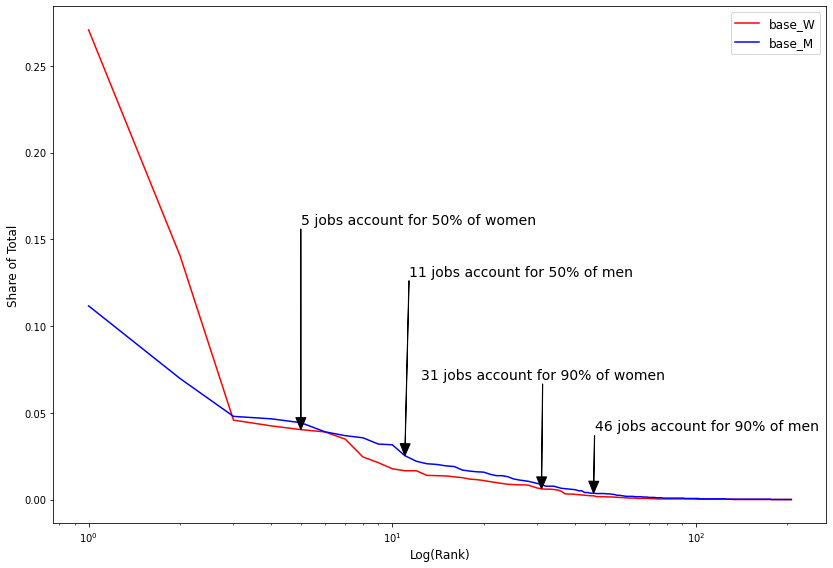

In [ ]:
make_rank_plot_xlnet(logy=False, logx=True)

## Gender Parity


In [ ]:
def select_plot_df(freq_matrix, intersection, criteria, THRESHOLD, TOP_N):
  '''Subsets dataframe for subsequent plots

  Args:
    freq_matrix: input one-hot encoded job matrix
    intersection: category for analysis from ['base', 'ethnicity', 'religion', 'sexuality', 'political', 'continent']
    criteria: method of selecting large man-woman difference by min-max range ('range') or standard deviation ('std')
    THRESHOLD: lower-bound of mentions to exclude infrequently mentioned jobs'
    TOP_N: Number of jobs to retain for plot.
    '''
  # Subset dataframe by intersection
  if intersection == 'continent':
    subset_df = freq_matrix
  else:
    if intersection == 'religion':
      subs = ['christian', 'buddhist', 'hindu', 'jewish' ,'muslim']
    elif intersection == 'ethnicity':
      subs = ['asian', 'black', 'hispanic', 'white']
    elif intersection == 'sexuality':
      subs = ['gay', 'straight']
    elif intersection == 'political':
      subs = ['conservative', 'liberal']
    elif intersection == 'base':
        subs = ['base']
    subset_df = freq_matrix[freq_matrix['category'].isin(subs)]  
  df_frequency = subset_df.groupby(['category', 'gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  # Apply threshold
  for token in df_frequency.columns:
    if df_frequency[token].aggregate(sum) < THRESHOLD:
      thresholds = thresholds.drop(columns = token)
  proportions = thresholds.div(thresholds.aggregate(sum))
  print(f'Number of categories: {proportions.shape[0]}, Number of Jobs > THRESHOLD: {proportions.shape[1]}')
  # Selection criteria
  if criteria == 'range':
    selection = proportions.aggregate(max) - proportions.aggregate(min)
  elif criteria == 'std':
    selection = proportions.aggregate(np.std)
  # Apply TOP-N and sort
  if TOP_N == 'NONE':
    selection = selection.sort_values(ascending = False)
  else:
    selection = selection.sort_values(ascending = False)
    selection = selection.nlargest(TOP_N)
  # Make dataFrame
  plot_df = proportions[list(selection.index)]
  idx_ref = plot_df.groupby('gender').aggregate(sum).loc['M'].sort_values(ascending = False).index
  plot_df = plot_df.loc[:, (idx_ref)]
  
  return plot_df

In [ ]:
#--->> DEFAULT PARAMETERS #
THRESHOLD = 500                           # remove all tokens whose cumulative sum (vertically) is below this threshold
TOP_N = 15                              # after the analysis, the number of tokens to be picked and ranked for each category (and showed in plots)

#--->> CREATING LABELS AND SETTING FONT SIZE FOR PLOTS BELOW
x_TICK_NUMBER = list(range(TOP_N))        # to create visual aids on plots (numbers on x-axis)
FONTSIZE = 14  

In [ ]:
def gender_parity_bar(freq_matrix, criteria, THRESHOLD, TOP_N):
  '''Creates barplot of top man-woman range for TOP_N jobs under THRESHOLD, selected by range or std criteria'''
  # Select plot data
  plot_df = select_plot_df(freq_matrix, 'base', criteria, THRESHOLD, TOP_N)
  plot_df = plot_df.aggregate(np.diff).aggregate(sum)
  # Set up subplots
  N_PLOTS = 1
  labels_plot = plot_df.index
  fig, ax = plt.subplots(nrows = N_PLOTS, figsize = (20, 4))
  x_TICK_NUMBER = list(range(TOP_N))
  print(f"Caption title:\nGender parity of {TOP_N} jobs.\nThreshold = {THRESHOLD}, criteria = {criteria}")
  # Plot bar
  ax.bar(x_TICK_NUMBER, plot_df.values, color = 'black', alpha = 0.7, zorder = 5)
  plt.sca(ax)
  plt.xticks(range(TOP_N), color = 'grey')
  plt.yticks([1,0,-1], labels = ['100% Men', 'Gender Parity', '100% Women'], fontsize = 14)           
  ax.grid(which = 'both', color = 'lightgrey', alpha = 0.5)
  ax.set_xlim((-1,TOP_N))
  ax.set_ylim((-1.05, 1.05))
  plt.hlines(0, -0.5, TOP_N-0.5, colors = 'red', linestyles = 'dashdot', zorder = 6)      # label = 'gender parity line',
  plt.text(0, -0.2, "Male-dominated jobs", color = 'red', fontsize = FONTSIZE)
  plt.text(43, 0.2, "Female-dominated jobs", color = 'red', fontsize = FONTSIZE)
  plt.xticks(x_TICK_NUMBER, labels_plot, rotation = 90, fontsize = FONTSIZE, color = 'black')
  # fig.savefig(f'./figs/gender_parity_xlnet.pdf', format='pdf', dpi=900, bbox_inches='tight')
  plt.show()

Number of categories: 2, Number of Jobs > THRESHOLD: 53
Caption title:
Gender parity of 53 jobs.
Threshold = 35, criteria = range


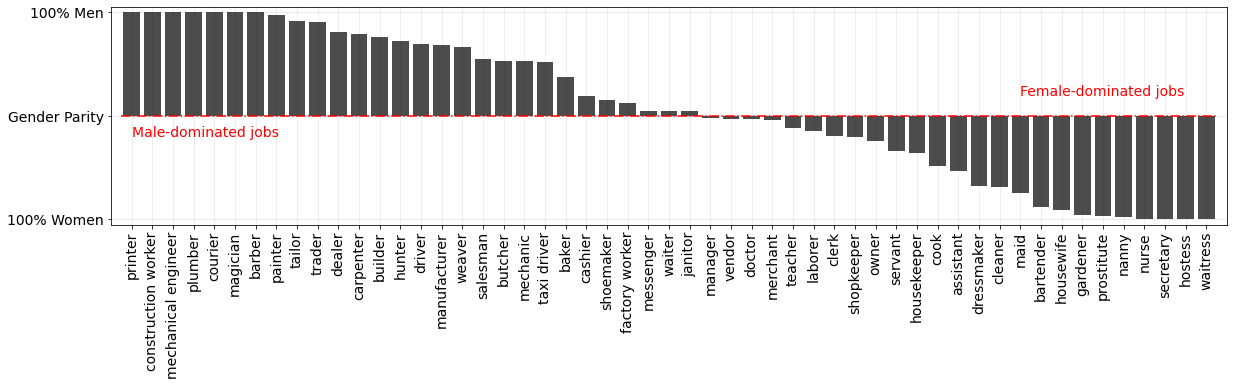

In [ ]:
gender_parity_bar(freq_matrix_xlnet, "range", 35, 53)

## Row Wise Proportions


In [ ]:
# Make row-wise sum
def row_wise_props(df):
  '''Converts counts to row-wise proportions'''
  df["sum"] = df.sum(axis=1)
  df_props = df.div(df['sum'], axis = 0)
  df_props = df_props.drop("sum", axis = 1)
  return df_props

def top_jobs_table(freq_matrix_cats, gender):
  '''Generates table for top 5 names per category for GPT predictions'''
  df = freq_matrix_cats.groupby(['category', 'gender']).aggregate(sum).astype(int)
  df = df.reset_index()
  df_gender = df[df['gender'] == gender]
  df_gender = df_gender.drop('gender', axis =1).set_index('category')
  df_row = row_wise_props(df_gender)
  x=pd.DataFrame(df_row).T
  cats = []
  results = {}
  for i in x.columns:
    results_i = {}
    df1row = x.nlargest(5, i)
    df1row = (df1row[i].astype('float64').round(2))
    props = df1row.to_list()
    index_list  = df1row.index.to_list()
    jobs = [s.replace('.1', '') for s in index_list]
    cats.append(i)
    tuple_list = []
    for job, prop in zip(jobs, props):
      job_tuple = f'{job} ({prop})'
      tuple_list.append(job_tuple)
    results_i['XLNET'] = tuple_list
    results_i['Sum_Props'] = sum(props)
    results[i] = results_i
  results_df = pd.DataFrame.from_dict(results, orient = 'index')
  return results_df

In [ ]:
fem_jobs_xlnet = top_jobs_table(freq_matrix_xlnet, 'F')
# fem_jobs_xlnet.to_csv('./data/xlnet/female_jobs_xlnet.csv')

In [ ]:
man_jobs_xlnet = top_jobs_table(freq_matrix_xlnet, 'M')
# man_jobs_xlnet.to_csv('./data/xlnet/male_jobs_xlnet.csv')